Stakeholder: PRAMS Pregnancy Monitoring Network

Business Problem: APGAR Score is a metric doctors use to measure the overall health of a newborn infant. But what if there were a way to prepare for a low APGAR score before the infant is even born? PRAMS has asked me to use natality data to create a model to alert medical staff if a newborn is likely to need emergency medical intervention.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [2]:
# Read in the data sets
df = pd.read_csv("data/nat2019us.csv")

C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.columns

Index(['dob_yy', 'dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'f_facility',
       'bfacil3', 'mage_impflg', 'mage_repflg', 'mager',
       ...
       'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 'f_ca_chrom', 'f_ca_hypos',
       'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed'],
      dtype='object', length=226)

In [4]:
df.head()

,dob_yy,dob_mm,dob_tt,dob_wk,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,...,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen,itran,ilive,bfed,f_bfed
0,2019,1,1135,3,1,1,1,NaN,NaN,29,...,1,1,1,1,1,1,N,Y,Y,1
1,2019,1,1305,3,1,1,1,NaN,NaN,40,...,1,1,1,1,1,1,N,Y,Y,1
2,2019,1,800,3,1,1,1,NaN,NaN,30,...,1,1,1,1,1,1,N,Y,Y,1
3,2019,1,130,4,1,1,1,NaN,NaN,25,...,1,1,1,1,1,1,N,Y,Y,1
4,2019,1,1426,4,1,1,1,NaN,NaN,38,...,1,1,1,1,1,1,N,Y,Y,1


In [5]:
df_copy = df.copy()

Columns are removed for the following reasons:
- They are storing metadata about the collection of the data minor processing tasks performed
- They are pre-binned for a specific purpose outside the scope of this analysis
- They are slight variations of existing columns which are more applicable to this analysis
- They represent events that happen after birth has already occurred

In [6]:
remove = ['dob_yy', 'f_facility', 'bfacil3', 'mage_impflg', 'mage_repflg', 'mager14', 'mager9', 'mrace31', 'mrace6', 'mrace15',
           'mraceimp', 'mhispx', 'f_mhisp', 'mracehisp', 'mar_p', 'mar_imp', 'f_mar_p', 'f_meduc', 'fagerpt_flg', 'fagerec11',
           'frace31', 'frace15', 'fhispx', 'f_fhisp', 'lbo_rec', 'tbo_rec', 'illb_r', 'illb_r11', 'ilop_r',
           'ilop_r11', 'ilp_r11', 'f_mpcb', 'precare5', 'previs_rec', 'f_tpcv', 'f_wic', 'cig0_r', 'cig1_r', 'cig2_r',
           'cig3_r', 'f_cigs_0', 'f_cigs_1', 'f_cigs_2', 'f_cigs_3', 'cig_rec', 'f_tobaco', 'f_m_ht', 'bmi_r', 'pwgt_r',
           'f_pwgt', 'f_dwgt', 'wtgain_rec', 'f_wtgain', 'f_rf_pdiab', 'f_rf_gdiab', 'f_rf_phyper', 'f_rf_ghyper', 
           'f_rf_eclamp', 'f_rf_ppb', 'f_rf_inf_drg', 'f_rf_inf_art', 'rf_cesar', 'f_rf_cesar', 'f_rf_ncesar',
           'no_risks', 'f_ip_gonor', 'f_ip_syph', 'f_ip_chlam', 'f_ip_hepatb', 'f_ip_hepatc', 'no_infec', 'ob_ecvs', 'ob_ecvf',
           'f_ob_succ', 'f_ob_fail', 'ld_indl', 'ld_augm', 'ld_anes', 'f_ld_indl', 'f_ld_augm', 'f_ld_ster', 'f_ld_antb',
           'f_ld_chor', 'f_ld_anes', 'no_lbrdlv', 'me_pres', 'me_rout', 'me_trial', 'f_me_pres', 'f_me_rout', 'f_me_trial',
           'rdmeth_rec', 'dmeth_rec', 'f_dmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_uhyst', 'mm_aicu', 'f_mm_mtr',
           'f_mm_rupt', 'f_mm_uhyst', 'f_mm_aicu', 'no_mmorb', 'mtran', 'pay', 'f_pay', 'f_pay_rec', 'apgar5r',
           'f_apgar5', 'apgar10', 'apgar10r', 'imp_plur', 'setorder_r', 'imp_sex', 'dlmp_mm', 'dlmp_yy', 'compgst_imp',
           'obgest_flg', 'gestrec10', 'gestrec3', 'lmpused', 'oegest_comb', 'oegest_r10', 'dbwt', 'bwtr12', 'bwtr4',
           'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'f_ab_vent', 'f_ab_vent6',
           'f_ab_surfac', 'f_ab_antibio', 'f_ab_seiz', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 
           'ca_gast', 'f_ca_anen', 'f_ca_menin', 'f_ca_heart', 'f_ca_hernia', 'f_ca_ompha', 'f_ca_gastro', 'ca_limb',
           'ca_cleft', 'ca_clpal', 'ca_disor', 'ca_hypo', 'f_ca_limb', 'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 
           'f_ca_chrom', 'f_ca_hypos', 'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed', 'f_mm_', 'f_ab_nicu', 'fracehisp',
           'oegest_r3', 'dob_mm', 'dob_tt', 'dob_wk', 'restatus', 'frace6', 'fhisp_r', 'feduc', 'ilp_r']

In [7]:
df.drop(remove, axis=1, inplace=True)
df.columns

Index(['bfacil', 'mager', 'mbstate_rec', 'restatus', 'mbrace', 'mhisp_r',
       'dmar', 'meduc', 'fagecomb', 'frace6', 'fhisp_r', 'feduc', 'priorlive',
       'priordead', 'priorterm', 'ilp_r', 'precare', 'previs', 'wic', 'cig_0',
       'cig_1', 'cig_2', 'cig_3', 'm_ht_in', 'bmi', 'dwgt_r', 'wtgain',
       'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_ppterm',
       'rf_inftr', 'rf_fedrg', 'rf_artec', 'rf_cesarn', 'ip_gon', 'ip_syph',
       'ip_chlam', 'ip_hepatb', 'ip_hepatc', 'ld_ster', 'ld_antb', 'ld_chor',
       'attend', 'pay_rec', 'apgar5', 'dplural', 'sex', 'combgest',
       'ca_downs'],
      dtype='object')

In [8]:
rename = ['birth_place', 'mother_age', 'mother_native',
          'mother_race', 'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
          'living_children', 'deceased_children', 'terminations', 
          'months_prenatal_care', 'prenatal_visits', 'food_assistance', 'prepregnancy_daily_cig',
          'first_tri_daily_cig', 'second_tri_daily_cig', 'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
          'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension', 'gestational_hypertension', 'eclampsia',
          'previous_premature_birth', 'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
          'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
          'chorioamnionitis', 'attendant', 'payment_method', 'apgar_score', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
          'down_syndrome']

In [9]:
df.columns = rename

## Target Engineering

In [10]:
df['apgar_score'].value_counts()

9     3094327
8      417480
7       77895
10      75873
6       30450
5       16107
99      14673
4        9028
1        7415
3        6507
2        5781
0        2046
Name: apgar_score, dtype: int64

In [11]:
df['apgar_score'].replace(to_replace=list(range(0, 7)), value=0, inplace=True)

In [12]:
df['apgar_score'].replace(to_replace=list(range(7, 11)), value=1, inplace=True)

In [14]:
df.drop(df.loc[df['apgar_score']==99].index, inplace=True)

In [15]:
df['apgar_score'].value_counts()

1    3665575
0      77334
Name: apgar_score, dtype: int64

## Feature Processing

In [16]:
df.columns

Index(['birth_place', 'mother_age', 'mother_nativity', 'mother_residence',
       'mother_race', 'mother_hispanic', 'marital_status', 'mother_education',
       'father_age', 'father_race', 'father_hispanic', 'father_education',
       'living_children', 'deceased_children', 'terminations',
       'months_last_pregnancy', 'first_prenatal_care_month', 'prenatal_visits',
       'food_assistance', 'prepregnancy_daily_cig', 'first_tri_daily_cig',
       'second_tri_daily_cig', 'third_tri_daily_cig', 'height', 'bmi',
       'delivery_weight', 'weight_gain', 'diabetes', 'gestational_diabetes',
       'hypertension', 'gestational_hypertension', 'eclampsia',
       'previous_premature_birth', 'infertility_treatment', 'fertility_drugs',
       'assisted_reproduction', 'previous_cesareans', 'gonorrhea', 'syphilis',
       'chlamydia', 'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'attendant', 'payment_method', 'apgar_score',
       'plural_pregnancy', 'infan

In [19]:
df['birth_place'].value_counts()

1    3686903
3      27698
2      20723
5       2559
4       2338
7       2096
6        530
9         62
Name: birth_place, dtype: int64

In [20]:
df['birth_place'].replace(to_replace=list(range(2, 8)), value="other", inplace=True)
df['birth_place'].replace(to_replace=1, value="hospital", inplace=True)
df['birth_place'].replace(to_replace=9, value=np.nan, inplace=True)

In [26]:
df['mother_native'].value_counts()

1    2885074
2     850158
3       7677
Name: mother_nativity, dtype: int64

In [27]:
df['mother_native'].replace(to_replace=2, value=0, inplace=True)
df['mother_native'].replace(to_replace=3, value=np.nan, inplace=True)

In [30]:
df['mother_race'].value_counts()

1    2788731
2     632382
4     280217
3      41579
Name: mother_race, dtype: int64

In [46]:
df['mother_race'].replace({1: 'white', 2: 'black', 3: 'native_american', 4: 'asian/pi'}, inplace=True)

In [48]:
# Place of birth
counts = (df[['mother_race', 'apgar_score']]
              .groupby(['mother_race', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

In [49]:
counts['percent_low_apgar'] = (counts[0]/counts[1])*100

In [50]:
counts['percent_low_apgar']

mother_race
asian/pi           1.605575
black              3.212339
native_american    2.391154
white              1.909498
Name: percent_low_apgar, dtype: float64

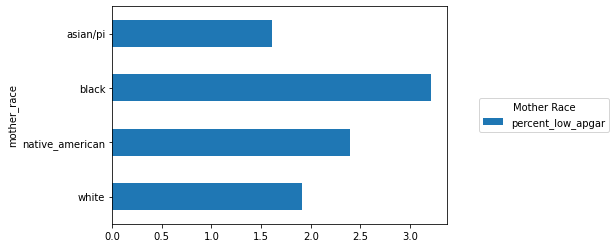

In [54]:
ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Mother Race'
)

In [55]:
df['mother_hispanic'].value_counts()

0    2816958
1     502208
4     164721
5     129573
2      70711
9      35104
3      23634
Name: mother_hispanic, dtype: int64

In [57]:
df['mother_hispanic'].replace(to_replace=list(range(1, 6)), value=1, inplace=True)
df['mother_hispanic'].replace(to_replace=9, value=np.nan, inplace=True)

In [59]:
df['marital_status'].value_counts()

1.0    1968696
2.0    1330007
Name: marital_status, dtype: int64

In [60]:
df['marital_status'].replace({1: 'married', 2: 'unmarried'}, inplace=True)

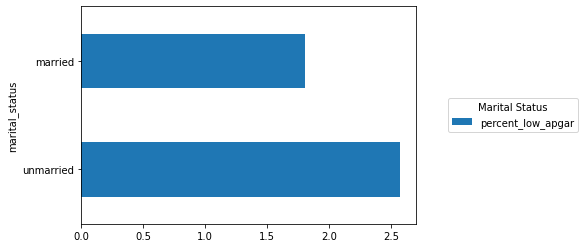

In [61]:
counts = (df[['marital_status', 'apgar_score']]
              .groupby(['marital_status', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Marital Status'
)

In [62]:
df['mother_education'].value_counts()

3    963465
6    772775
4    727697
7    360017
2    336834
5    309359
1    115068
8    104489
9     53205
Name: mother_education, dtype: int64

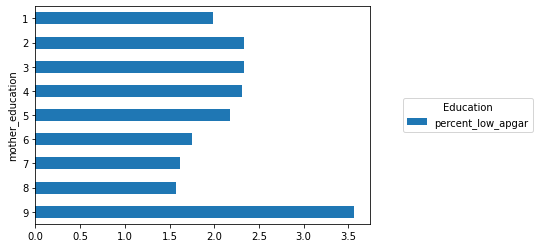

In [63]:
counts = (df[['mother_education', 'apgar_score']]
              .groupby(['mother_education', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Education'
)

In [64]:
df['mother_education'].replace(to_replace=list(range(1, 6)), value="hs_or_lower", inplace=True)
df['mother_education'].replace(to_replace=list(range(6, 9)), value="college_or_higher", inplace=True)
df['mother_education'].replace(to_replace=9, value=np.nan, inplace=True)

In [66]:
df['father_age'].value_counts()

99    430117
31    202868
32    200782
30    197125
33    197000
       ...  
93         1
86         1
84         1
98         1
87         1
Name: father_age, Length: 80, dtype: int64

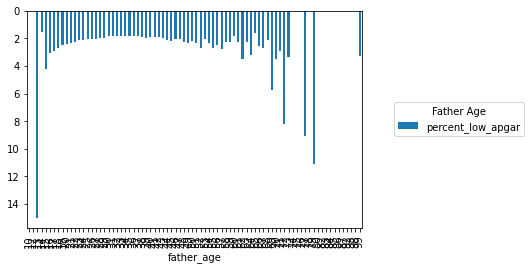

In [68]:
counts = (df[['father_age', 'apgar_score']]
              .groupby(['father_age', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Father Age'
)

In [69]:
df['father_age'].replace(to_replace=99, value=np.nan, inplace=True)

In [71]:
df['living_children'].value_counts()

0     1437973
1     1193311
2      637706
3      274877
4      107747
5       45341
6       20164
7        9821
99       5041
8        4979
9        2845
10       1637
11        811
12        413
13        129
14         66
15         27
16         13
17          4
20          2
18          2
Name: living_children, dtype: int64

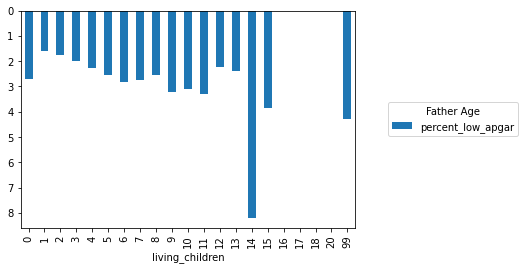

In [72]:
counts = (df[['living_children', 'apgar_score']]
              .groupby(['living_children', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Living Children'
)

In [73]:
df['living_children'].replace(to_replace=99, value=np.nan, inplace=True)

In [74]:
df['deceased_children'].value_counts()

0     3691909
1       36560
99       7396
2        4564
3        1112
4         399
5         231
9         158
6         152
7         124
8         119
10         87
12         49
11         48
17          1
Name: deceased_children, dtype: int64

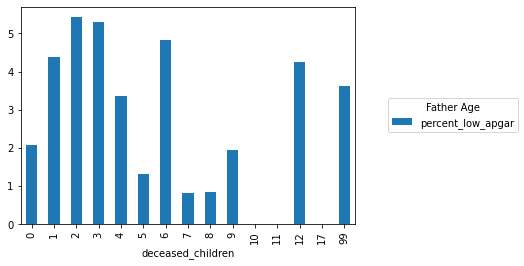

In [76]:
counts = (df[['deceased_children', 'apgar_score']]
              .groupby(['deceased_children', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Deceased Children'
)

In [77]:
df['deceased_children'].replace(to_replace=99, value=np.nan, inplace=True)

In [79]:
df['terminations'].value_counts()

0     2710073
1      667012
2      226272
3       78874
4       28715
5       11658
99       8340
6        5211
7        2680
8        1476
9         882
10        802
11        348
12        260
13         97
14         63
15         54
16         32
17         14
18         14
23          8
20          7
19          6
25          3
30          2
22          2
21          2
24          1
27          1
Name: terminations, dtype: int64

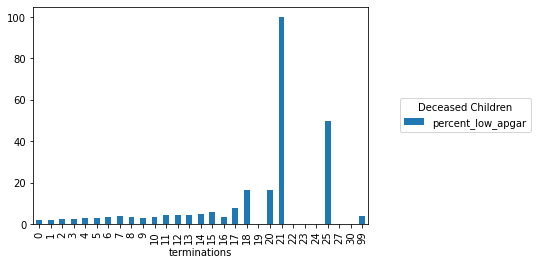

In [80]:
counts = (df[['terminations', 'apgar_score']]
              .groupby(['terminations', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Terminations'
)

In [83]:
df['terminations'].replace(to_replace=99, value=np.nan, inplace=True)

In [82]:
df['months_prenatal_care'].value_counts()

2     1475542
3     1152091
4      323210
1      212144
5      163052
6      100782
99      83396
7       79773
0       66419
8       61274
9       24838
10        388
Name: first_prenatal_care_month, dtype: int64

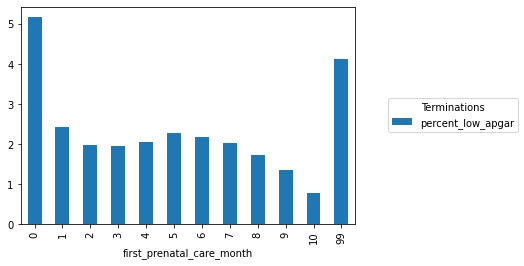

In [84]:
counts = (df[['months_prenatal_care', 'apgar_score']]
              .groupby(['months_prenatal_care', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Prenatal Care'
)

In [ ]:
df['months_prenatal_care'].replace(to_replace=99, value=np.nan, inplace=True)

In [85]:
df['prenatal_visits'].value_counts()

12    576719
10    481612
11    377871
13    358086
14    299447
       ...  
94         1
86         1
73         1
74         1
83         1
Name: prenatal_visits, Length: 92, dtype: int64

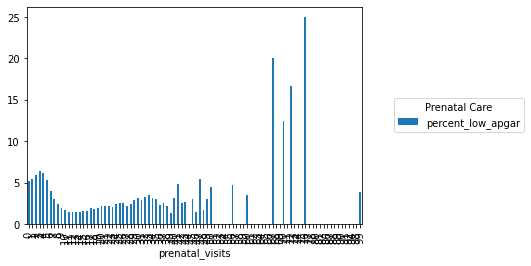

In [86]:
counts = (df[['prenatal_visits', 'apgar_score']]
              .groupby(['prenatal_visits', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Prenatal Visits'
)

In [87]:
df['prenatal_visits'].replace(to_replace=99, value=np.nan, inplace=True)

In [88]:
df['food_assistance'].value_counts()

N    2447990
Y    1252530
U      42389
Name: food_assistance, dtype: int64

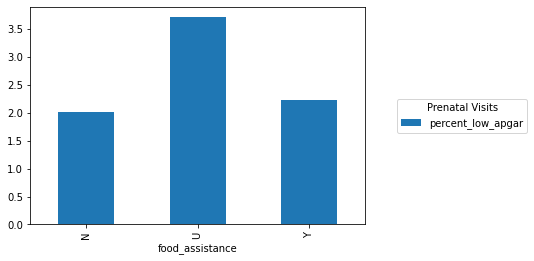

In [89]:
counts = (df[['food_assistance', 'apgar_score']]
              .groupby(['food_assistance', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Food Assistance'
)

In [90]:
df['prenatal_visits'].replace(to_replace='U', value=np.nan, inplace=True)

In [91]:
df['prepregnancy_daily_cig'].value_counts()

0     3438762
20      84271
10      76956
5       30445
99      18529
       ...   
54          1
71          1
52          1
76          1
56          1
Name: prepregnancy_daily_cig, Length: 74, dtype: int64

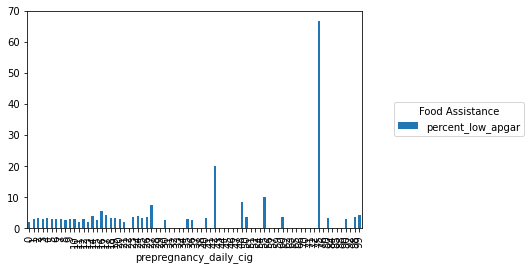

In [92]:
counts = (df[['prepregnancy_daily_cig', 'apgar_score']]
              .groupby(['prepregnancy_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Food Assistance'
)

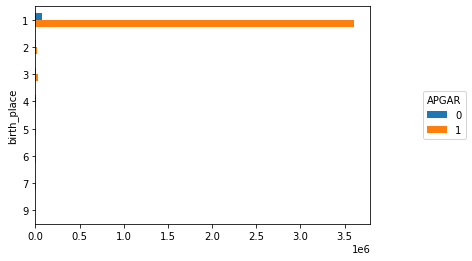

In [18]:
# Place of birth
counts = (df[['birth_place', 'apgar_score']]
              .groupby(['birth_place', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='APGAR'
)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757582 entries, 0 to 3757581
Data columns (total 52 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   birth_place                int64  
 1   mother_age                 int64  
 2   mother_nativity            int64  
 3   mother_residence           int64  
 4   mother_race                int64  
 5   mother_hispanic            int64  
 6   marital_status             float64
 7   mother_education           int64  
 8   father_age                 int64  
 9   father_race                int64  
 10  father_hispanic            int64  
 11  father_education           int64  
 12  living_children            int64  
 13  deceased_children          int64  
 14  terminations               int64  
 15  months_last_pregnancy      int64  
 16  first_prenatal_care_month  int64  
 17  prenatal_visits            int64  
 18  food_assistance            object 
 19  prepregnancy_daily_cig     int64  
 20  fi

In [ ]:
df_cat = df.select_dtypes(include=['object'])

In [23]:
df_num = df.select_dtypes(include=['int64', 'float64'])

,birth_month,birth_time,birth_day,birth_place,mother_age,mother_nativity,mother_residence,mother_race,mother_hispanic,marital_status,...,height,bmi,delivery_weight,weight_gain,previous_cesareans,attendant,payment_method,apgar_score,plural_pregnancy,weeks_gestation
0,1,1135,3,1,29,1,1,3,0,1.0,...,62,29.8,191,28,0,3,2,8,1,40
1,1,1305,3,1,40,2,1,4,0,1.0,...,66,24.2,204,54,0,1,1,9,1,39
2,1,800,3,1,30,1,1,3,0,1.0,...,61,20.8,159,49,0,3,9,8,1,38
3,1,130,4,1,25,1,1,1,0,1.0,...,64,23.2,154,19,0,2,2,9,1,38
4,1,1426,4,1,38,1,1,1,0,2.0,...,63,22.1,158,33,0,1,2,9,1,37


In [16]:
for c in df_cat.columns:
    print("---- %s ---" % c)
    print(df[c].value_counts())

---- food_assistance ---
N    2457297
Y    1256694
U      43591
Name: food_assistance, dtype: int64
---- diabetes ---
N    3717529
Y      36603
U       3450
Name: diabetes, dtype: int64
---- gestational_diabetes ---
N    3495054
Y     259078
U       3450
Name: gestational_diabetes, dtype: int64
---- hypertension ---
N    3670933
Y      83199
U       3450
Name: hypertension, dtype: int64
---- gestational_hypertension ---
N    3462061
Y     292071
U       3450
Name: gestational_hypertension, dtype: int64
---- eclampsia ---
N    3743594
Y      10538
U       3450
Name: eclampsia, dtype: int64
---- previous_premature_birth ---
N    3617523
Y     136609
U       3450
Name: previous_premature_birth, dtype: int64
---- infertility_treatment ---
N    3677981
Y      76151
U       3450
Name: infertility_treatment, dtype: int64
---- fertility_drugs ---
X    3677981
N      43102
Y      29041
U       7458
Name: fertility_drugs, dtype: int64
---- assisted_reproduction ---
X    3677981
Y      48957
N   

In [17]:
df_cat.columns

Index(['food_assistance', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c',
       'steroids', 'antibiotics', 'chorioamnionitis', 'infant_sex',
       'down_syndrome'],
      dtype='object')

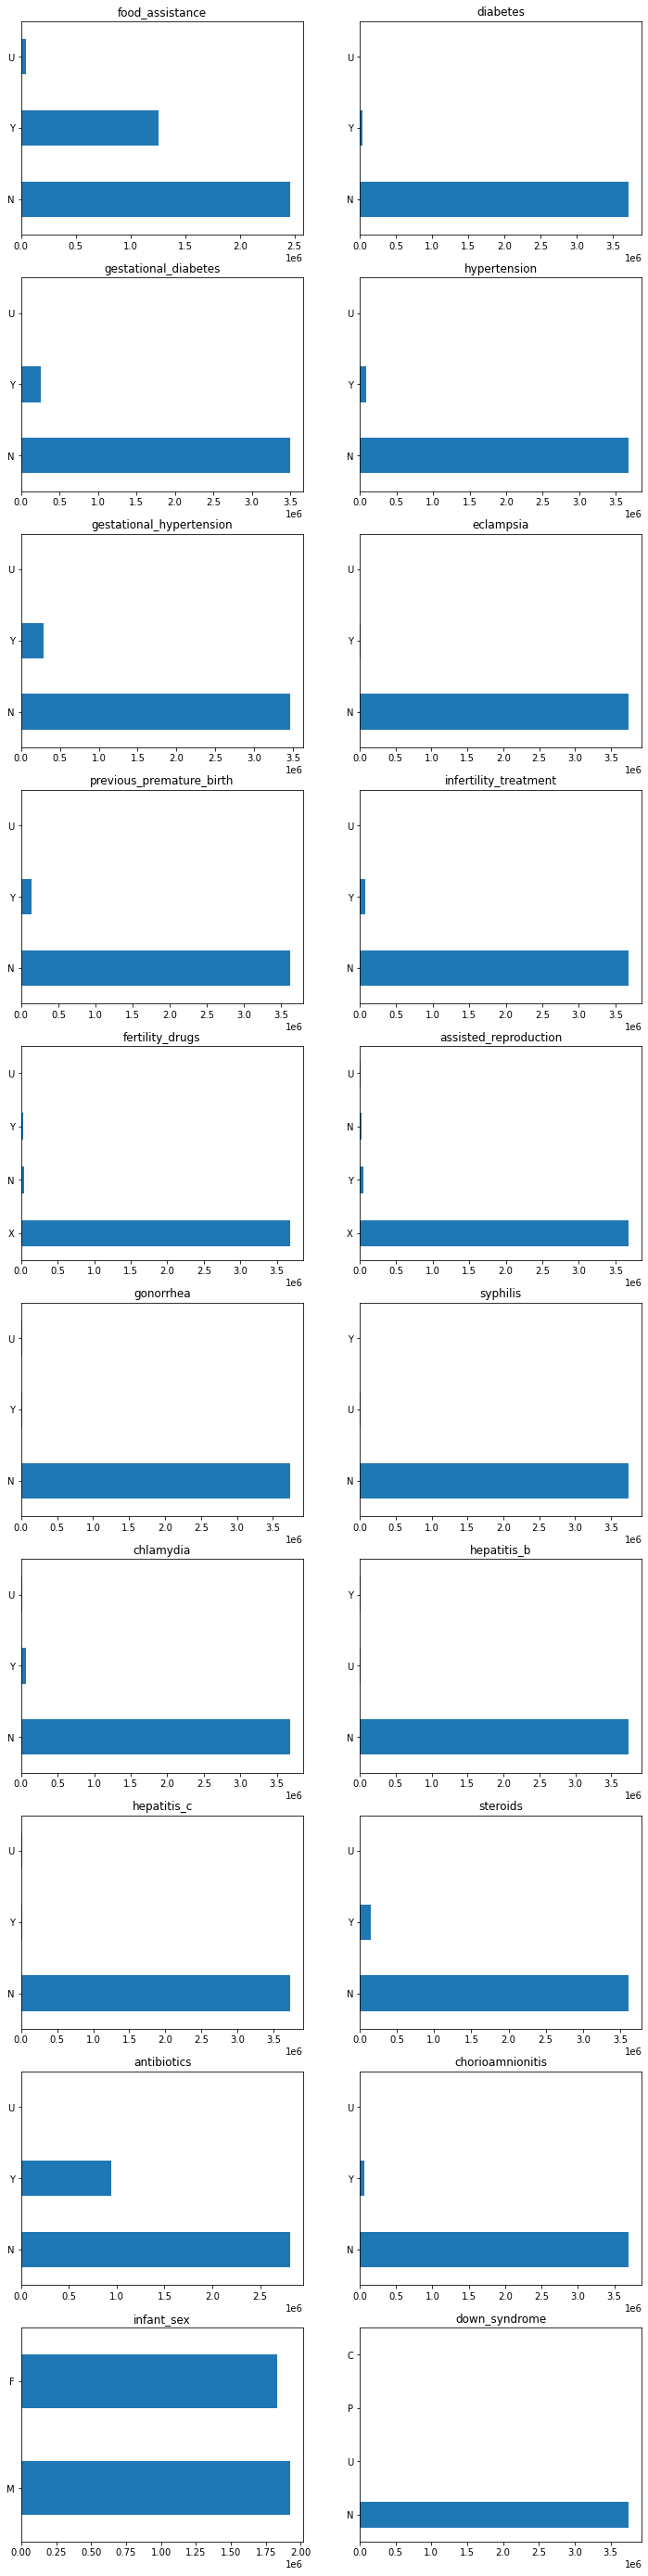

In [21]:
fig, axis = plt.subplots(nrows = int((len(df_cat.columns)/2)), ncols = 2, figsize=(12,len(df_cat.columns)*2.5))

for i, subplot in zip(df_cat.columns, axis.ravel()):
    df_cat[i].value_counts().plot(kind='barh', ax=subplot, title = i)

In [ ]:
fig, axis = plt.subplots(nrows = int((len(df_cat.columns)/2)), ncols = 2, figsize=(12,len(df_cat.columns)*2.5))

for i, subplot in zip(df_cat.columns, axis.ravel()):
    df_cat[i].value_counts().plot(kind='barh', ax=subplot, title = i)

<ipython-input-22-db2104ea8bab>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=axis, bins='auto')


array([[<AxesSubplot:title={'center':'birth_month'}>,
        <AxesSubplot:title={'center':'birth_time'}>,
        <AxesSubplot:title={'center':'birth_day'}>,
        <AxesSubplot:title={'center':'birth_place'}>,
        <AxesSubplot:title={'center':'mother_age'}>,
        <AxesSubplot:title={'center':'mother_nativity'}>],
       [<AxesSubplot:title={'center':'mother_residence'}>,
        <AxesSubplot:title={'center':'mother_race'}>,
        <AxesSubplot:title={'center':'mother_hispanic'}>,
        <AxesSubplot:title={'center':'marital_status'}>,
        <AxesSubplot:title={'center':'mother_education'}>,
        <AxesSubplot:title={'center':'father_age'}>],
       [<AxesSubplot:title={'center':'father_race'}>,
        <AxesSubplot:title={'center':'father_hispanic'}>,
        <AxesSubplot:title={'center':'father_education'}>,
        <AxesSubplot:title={'center':'living_children'}>,
        <AxesSubplot:title={'center':'deceased_children'}>,
        <AxesSubplot:title={'center':'termina

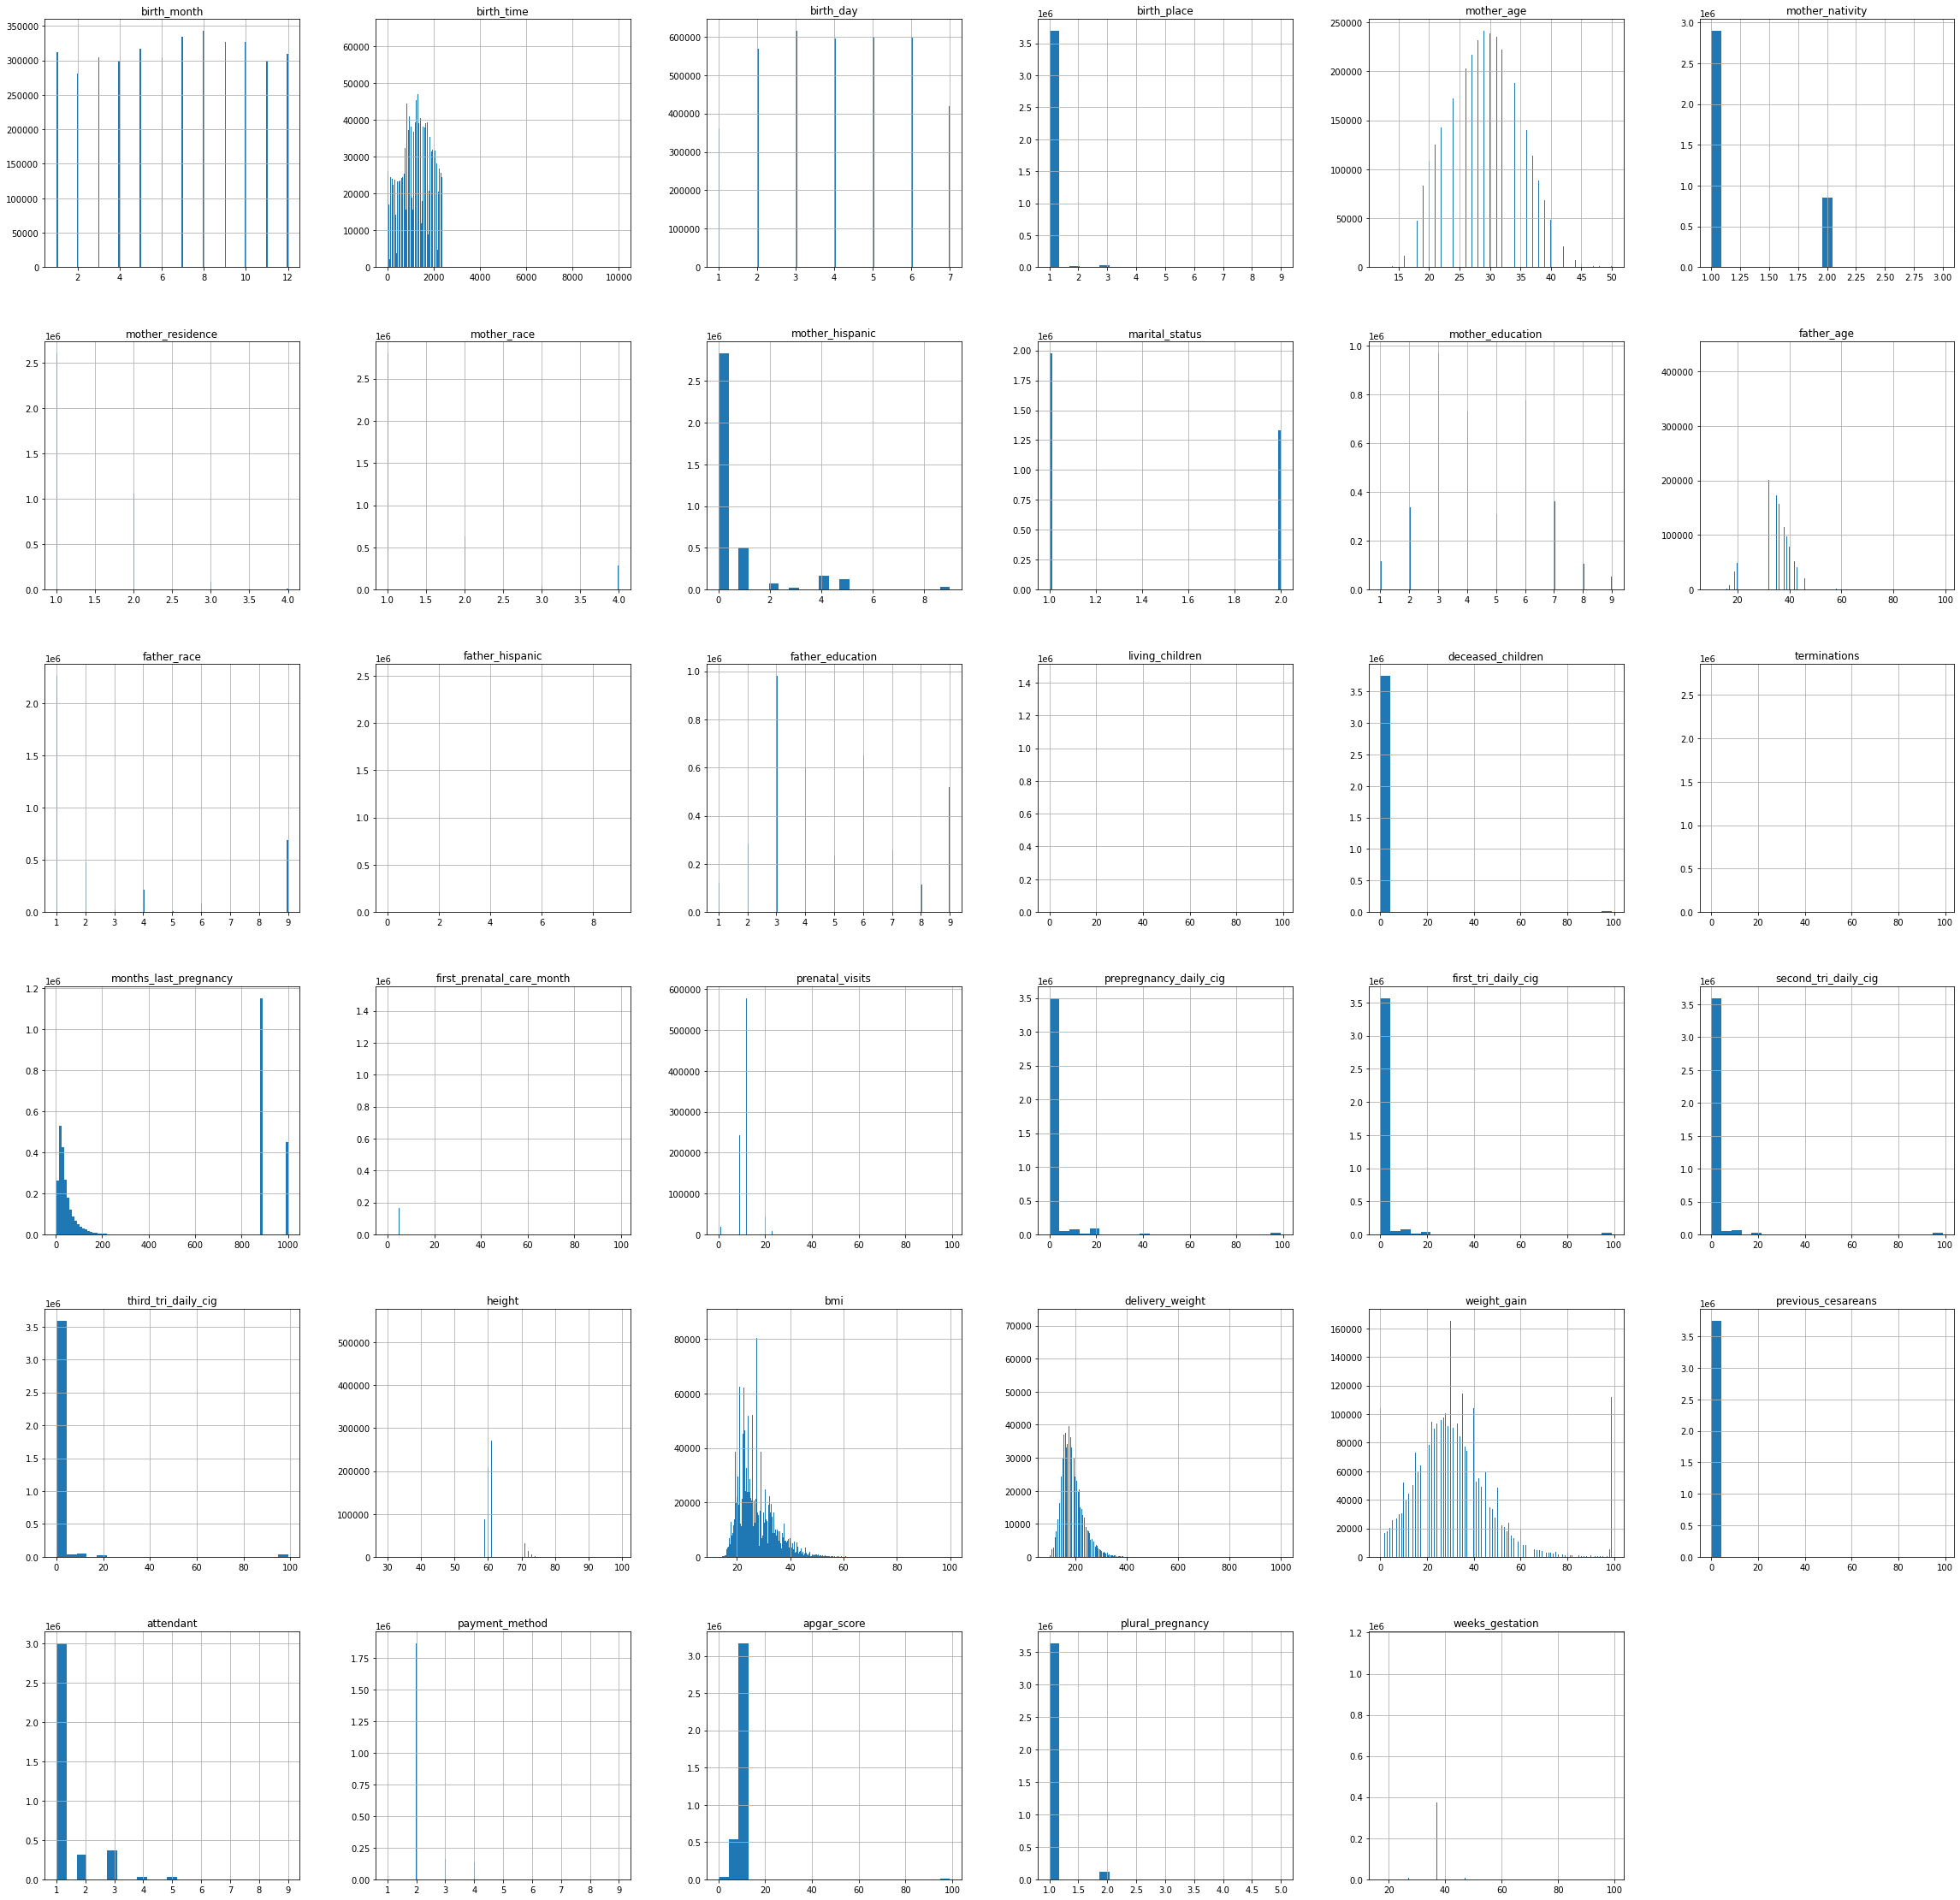

In [22]:
fig, axis = plt.subplots(figsize=(40, 40))
df.hist(ax=axis, bins='auto')